![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx.ai and LangGraph to build Adaptive RAG Graph

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.


## Notebook content

This notebook contains the steps and code to demonstrate how to build Adaptive RAG application using [LangGraph](https://langchain-ai.github.io/langgraph/) and watsonx.ai models.

Some familiarity with Python is helpful. This notebook uses Python 3.10.


## Learning goal

The purpose of this notebook is to demonstrate how to use language models, e.g. `meta-llama/llama-3-70b-instruct` and create Adaptive RAG applications using the tools available in LangGraph. LangGraph is an Agent Orchestrator with which you can build graph applications that automatically execute sequences of actions and in which the LLM is the key decision maker that determines the next step.


## Contents

This notebook contains the following parts:
- [Setup](#setup)
- [Adaptive RAG Graph](#arag_graph)
- [Example](#example)
- [Summary](#summary)

<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).

### Install and import dependecies

In [ ]:
!pip install "ibm-watsonx-ai>=1.0.1" | tail -n 1
!pip install langchain | tail -n 1
!pip install langchain-community | tail -n 1
!pip install langchain-ibm | tail -n 1
!pip install langchainhub | tail -n 1
!pip install chromadb | tail -n 1
!pip install langgraph | tail -n 1

# need to visualize the graph
!pip install pygraphviz | tail -n 1
# need to download content from webpages
!pip install bs4 | tail -n 1     

### Defining the WML credentials
This cell defines the WML credentials required to work with watsonx Foundation Model inferencing.

**Action:** Provide the IBM Cloud user API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">documentation</a>.

In [1]:
import getpass

credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": getpass.getpass("Please enter your WML api key (hit enter): ")
}

### Defining the project id
The Foundation Model requires project id that provides the context for the call. We will obtain the id from the project in which this notebook runs. Otherwise, please provide the project id.

In [7]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")

<a id="arag_graph"></a>
## Adaptive RAG Graph
Adaptive RAG is a RAG strategy that combines query analysis with self-correcting RAG. The basic idea behind the LangGraph orchestrator is to capture the entire flow of a selected RAG strategy in graph form. In general, each node in our graph where we call the LLM may have a different model underneath. Therefore, before each step definition, we initialize a separate llm with a specific set of generation parameters.

Below example is prepared based on the LangGraph [tutorial](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/).

### Initialise WatsonxEmbeddings

To embed documents needed for RAG we use IBM watsonx.ai embeddings.

In [8]:
from langchain_ibm import WatsonxEmbeddings, WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenTextParams

In [9]:
embeddings = WatsonxEmbeddings(model_id='ibm/slate-125m-english-rtrvr',
                               apikey=credentials.get('apikey'),
                               url=credentials.get('url'),
                               project_id=project_id)

### Create VectorStore and Retriever

As additional data, we will use information about IBM watsonx.ai, watsonx Orchestrate and watsonx Assistant, which can be found on the official pages of the aforementioned products.

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://www.ibm.com/products/watsonx-ai",
    "https://www.ibm.com/products/watsonx-orchestrate?lnk=flatitem",
    "https://www.ibm.com/products/watsonx-assistant?lnk=flatitem"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)


Next, we create a collection in Chromadb and add documents.

In [11]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma-watsonx",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

### Router stage

Entry stage in our graph. At this step the LLM decides what path to take to generate response for user question: either using llm's own knowledge or to use the most relevant documents from vector store to improve the response.

In [12]:
llm_route = WatsonxLLM(model_id='meta-llama/llama-3-70b-instruct',
                       apikey=credentials.get('apikey'),
                       url=credentials.get('url'),
                       project_id=project_id,
                       params={
                           GenTextParams.MAX_NEW_TOKENS: 20,
                           GenTextParams.DECODING_METHOD: "greedy"
                           })

In [13]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template="""You are an expert at routing a user question to a vectorstore.
    Use the vectorstore for questions on IBM watsonx.ai, watsonx Orchestrate and watsonx Assistant products.
    You do not need to be stringent with the keywords in the question related to these topics.
    Otherwise, use own knowledge. Based on the question, choose one type of datasource: 'own_knowledge' or 'vectorstore'.
    Return the a JSON with a single key 'datasource' and no premable or explanation. Use format
    ```
    {{
    "datasource": $DATASOURCE
    }}
    ```
    Question to route:\n{question}\nAnswer:\n""",
    input_variables=["question"],
)

question_router = prompt | llm_route | JsonOutputParser()

Let's check how `question_router` is working.

In [14]:
question = "what is a RAG problem?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

{'datasource': 'own_knowledge'}


### Retrieval Grader
One node in our adaptive RAG graph will be concerned with evaluating downloaded documents. The purpose of this stage is to let the LLM decide whether all retrieved documents are relevant for the user question. Since for the purposes of this example we do not need separate llm in this stage we are going to reuse llm from route stage.

In [15]:
llm_retrieval = llm_route

In [16]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser


prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm_retrieval | JsonOutputParser()

Let see whether second document on the list `docs` is proper for our test question.

In [17]:
question = "what is a watsonx Assistant?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


### Generate
The pivotal node of our graph. The purpose of this node is to generate a response based on the retrieved relevant documents or the model's own knowledge. Since the prompt for the scenario where the model needs to use "own" knowledge to generate the response may be slightly different from the RAG prompt, we create a separate one, `rag_simple_chain`. On the other hand, for the RAG route we download a specially adopted prompt from LangChain hub.

Moreover, the llm used at this stage should be able to generate a relatively long response, so we initialize a new llm where we set an appropriately large value for the `max_new_tokens` parameter.

In [18]:
llm_generate = WatsonxLLM(model_id='meta-llama/llama-3-70b-instruct',
                          apikey=credentials.get('apikey'),
                          url=credentials.get('url'),
                          project_id=project_id,
                          params={
                              GenTextParams.MAX_NEW_TOKENS: 100
                              })

In [19]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

prompt = hub.pull("rlm/rag-prompt")
prompt_simple = PromptTemplate.from_template("""You are an assistant for question-answering tasks. If you don't know the answer, 
                                             just say that you don't know. Use three sentences maximum and keep the answer concise.
                                             Question:\n{question}\nAnswer:""")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm_generate | StrOutputParser()
# Simply Chain
rag_simple_chain = prompt_simple | llm_generate | StrOutputParser()

In [21]:
question = "What is a loan?"
generation = rag_simple_chain.invoke({"question": question})
print(generation)

 
A loan is a sum of money borrowed from a lender, typically with an agreement to pay it back with interest. The borrower receives the loan amount upfront and repays it over time, usually in installments. Loans can be used for various purposes, such as buying a house, financing education, or covering unexpected expenses.


### Hallucination Grader
Hallucination is one of the phenomena that may occur when LLM generate a new content. It appears when a large language model generates a response that is either factually incorrect or ungrounded in the input prompt.

Since a separate llm is not needed for our purposes, so we will reuse the one created in the route stage.

In [22]:
llm_hallucination = llm_route

In [23]:
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm_hallucination | JsonOutputParser()

Let us check if our documents are relevant to the generated above text.

In [24]:
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'no'}

### Answer Grader

After LLM generates an answer, we check whether it answers the user's question. We are going to use the same llm as in route stage.

In [25]:
llm_grader = llm_route

In [26]:
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm_grader | JsonOutputParser()

Generated LLM's response should be directly related to the user's question.

In [27]:
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

### Question Re-writer
Finally, when the selected documents are not appropriate for the question or the generated answer is not good enough, we can use LLM to rewrite the question in such a way that the newly retrieved documents will better match it.

In [28]:
llm_question_rewriter = WatsonxLLM(model_id='ibm/granite-13b-chat-v2',
                                  apikey=credentials.get('apikey'),
                                  url=credentials.get('url'),
                                  project_id=project_id,
                                  params={
                                      GenTextParams.STOP_SEQUENCES: ["\n\n"]
                                 })

In [29]:
re_write_prompt = PromptTemplate(
    template="""You are a question re-writer that converts an input question to a better version that is optimized
     for vectorstore retrieval. Look at the given question and formulate an improved question keeping the meaning.\n
     Here is the initial question:\n{question}\nImproved question:\n""",
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm_question_rewriter | StrOutputParser()

In [30]:
question_rewriter.invoke({"question": question})

'What is a loan and how does it work?\n\n'

### Graph state

Graph state is one of the central concepts of LangGraph. Each nodes action creates a state that is passed between nodes in the graph as they execute.

In [31]:
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: list[str]

### Nodes action

The execution of an action by a node updates the internal state of the graph. Note that actions are defined by a custom function.

In [38]:
def retrieve(state: dict) -> dict:
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state: dict) -> dict:
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    if documents is not None:
        generation = rag_chain.invoke({"context": documents, "question": question})
    else:
        generation = rag_simple_chain.invoke({"question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state: dict) -> dict:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state: dict) -> dict:
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Set Conditional Edges

The next node to call is selected based on the current node's decision. Therefore, we need to set conditional functions on the edges to make the executor follow the right path. 

In [39]:
def route_question(state: dict) -> str:
    """
    Route question to classical generation or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    if source["datasource"] == "own_knowledge":
        print("---ROUTE QUESTION TO GENERATE---")
        return "own_knowledge"
    else:
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state: dict) -> str:
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state: dict) -> str:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    if documents is not None:
        print("---CHECK HALLUCINATIONS---")
        score = hallucination_grader.invoke(
            {"documents": documents, "generation": generation}
        )
        grade = score["score"]
    else:
        grade = "n/a"

    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    elif grade == 'n/a':
        return "useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Build graph

Since all needed components are ready, we can proceed to build an Adaptive RAG Graph.

In [40]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Add entry point and conditional edges
workflow.set_conditional_entry_point(
    route_question,
    {
        "own_knowledge": "generate",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

Compile the graph.

In [41]:
app = workflow.compile()

Moreover, to better understand the flow in our graph one can visualize it.

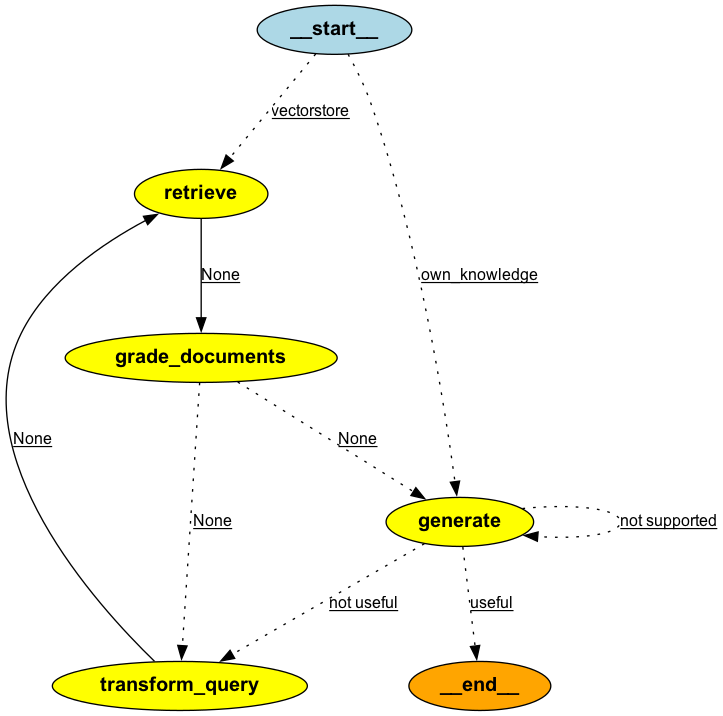

In [42]:
from IPython.display import Image

Image(app.get_graph().draw_png())

<a id="example"></a>
## Example

Now let us test our adaptive RAG graph and see which path Agent will choose if we pass a question about an object for which a description can be found in the vector store.

In [43]:
q = "What are the use cases for IBM watsonx Orchestrate? "

inputs = {"question": q}
for output in app.stream(inputs):
    for key, value in output.items():
        text = f"Node '{key}'"
        print("*"*(len(text) + 4))
        print(f"| {text} |")
        print("*"*(len(text) + 4))
    
for chunk in value["generation"]:
    print(chunk, end='', flush=True)

---ROUTE QUESTION---
What are the use cases for IBM watsonx Orchestrate? 
---ROUTE QUESTION TO RAG---
---RETRIEVE---
*******************
| Node 'retrieve' |
*******************
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
**************************
| Node 'grade_documents' |
**************************
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
*******************
| Node 'generate' |
*******************
 IBM Watsonx Orchestrate can be used to support human resource teams and talent acquisition teams by automating repetitive tasks and streamlining workflows. It can also be used to reduce errors and alleviate operational burdens in other industries. Additionally, it can help increase p

Next, let us check how the Agent will behave if we pass a question unrelated to the data stored in the vector store.

In [44]:
q = "what is a loan?"

inputs = {"question": q}
for output in app.stream(inputs):
    for key, value in output.items():
        text = f"Node '{key}'"
        print("*"*(len(text) + 4))
        print(f"| {text} |")
        print("*"*(len(text) + 4))
for chunk in value["generation"]:
    print(chunk, end='', flush=True)

---ROUTE QUESTION---
what is a loan?
---ROUTE QUESTION TO GENERATE---
---GENERATE---
*******************
| Node 'generate' |
*******************
 A loan is a sum of money borrowed from a lender, typically with an agreement to pay it back with interest over a set period of time. The borrower receives the loan amount upfront and repays it in installments. Loans can be used for various purposes, such as buying a house, financing education, or covering unexpected expenses.

If we ask a question whose content is related to data stored in the vector store, then the application will choose the RAG path. However, when the question is not related to the data stored in the vector store, the LLM will choose to use its "own" knowledge and generate an answer. 

<a id="summary"></a>
## Summary and next steps

 You successfully completed this notebook!
 
 You learned how to build Adaptive RAG graph using LangGraph and `WastonxLLM`.
 
Check out our _<a href="https://ibm.github.io/watson-machine-learning-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors:
 **Mateusz Świtała**, Software Engineer at Watson Machine Learning.

Copyright © 2024 IBM. This notebook and its source code are released under the terms of the MIT License.